# Análisis exploratorio - Precios de viviendas en USA

El objetivo de la presente exploración es encontrar las variables más influyentes en el precio de venta de las viviendas en los Estados Unidos. Específicamente en el estado de California. Este ejercicio es netamente práctico y no tiene fines comerciales.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings

%matplotlib inline

In [2]:
df = pd.read_csv('pricehouses.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape #Exploramos el tamaño del dataset. Para el análisis tendremos 1459 registros de ventas de casas en Estados Unidos

(1460, 81)

In [5]:
df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

Al explorar las columnas con el parámetro Shape podemos observar las variables que se tuvieron en cuenta en el dataset, 
las cuales nos pueden servir para el análisis.

In [6]:
df[['Id','SalePrice']]

,Id,SalePrice
0,1,208500
1,2,181500
2,3,223500
3,4,140000
4,5,250000
...,...,...
1455,1456,175000
1456,1457,210000
1457,1458,266500
1458,1459,142125


## Análisis de precios de venta

Empezamos por conocer las medidas de dispersión del precio de venta, es decir, el precio promedio, la desviación estándar,
el precio mínimo y el máximo y la distribución por cuartiles. Esto lo logramos con el parámetro .describe() y nos permite partir de un panorama más claro.

In [7]:
df['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

C:\Users\USUARIO\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

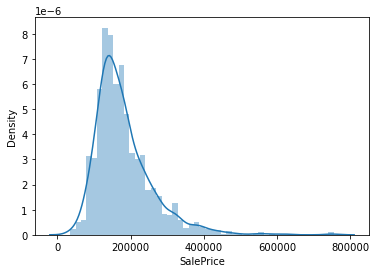

In [8]:
sns.distplot(df['SalePrice'])

A partir del gráfico podemos observar lo siguiente: 
 - La distribución de precios se desvía de la distribución normal
 - La distribución presenta una asimetría u oblicuidad positiva, es decir, hay valores más separados de la media hacia la derecha (valor máximo) que hacia la izquierda (valor mínimo)
 - También podemos ver que se presenta una distribución leptocúrtica, es decir, la distribución presenta una alta concentración al rededor de los valores centrales
 
 Para constatar esto, podemos consultar la asimetría/oblicuidad (skewness) y la curtosis (kurtosis) con los siguientes parámetros:

In [9]:
df['SalePrice'].skew()

1.8828757597682129

El valor positivo de asimetría nos confirma que la cola derecha de la distribución es más larga, es decir, hay valores más separados de la media hacia la derecha como se indicó previamente.

In [10]:
df['SalePrice'].kurt()

6.536281860064529

La curtosis positiva nos indica que la distribución presenta más valores atípicos extremos que una distribución normal.

### Análisis categórico

Para el análisis categórico observaremos la distribución del precio de venta de las casas vs otras variables. Dada la cantidad de variables en el dataset, partiré de una hipótesis para analizar primero aquella variable que creo es las más determinante a la hora de definir el precio de venta de una vivienda: el área.

Este análisis lo podemos iniciar con un scatter plot o gráfico de dispersión, tomando como valores en el eje X la variable independiente (Área) y en el eje Y la variable dependiente (Precio de venta).

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

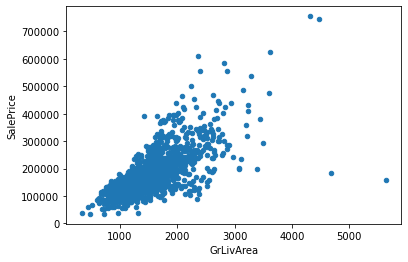

In [11]:
df.plot.scatter(x='GrLivArea', y='SalePrice')

De esta primera gráfica podemos observar una relación lineal, es decir, a mayor cantidad de área, mayor es el precio. Esto con algunas excepciones de un par de casas cuya área es mayor a 4.700 y su precio de venta es inferior a $200.000 USD, pero estos valores son los que llamamos outliers y no afectan el análisis.

¿Tiene influencia el tamaño del sótano en el precio de venta de las casas? Para observar si hay alguna linealidad graficaremos el precio en función de la variable *TotalBsmtSF* que almacena el área de los sótanos.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


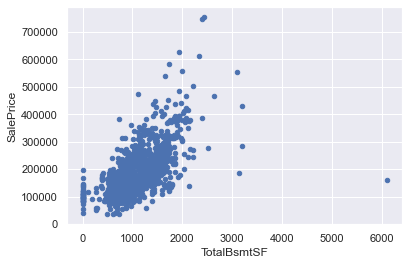

In [31]:
df.plot.scatter(x='TotalBsmtSF', y='SalePrice')
plt.show()

Si bien se puede apreciar una relación lineal también, en ocasiones el tamaño del sótano evita el precio de venta.

**¿Qué tal si el hecho de tener o no piscina es relevante en el precio?** Si le pregunto a mi yo de 10 años esto tendría total sentido, ¿qué podría ser mejor que una casa con piscina? Pues bien, grafiquemos el precio en función de la variable *PoolArea* y analicemos si existe una linealidad.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


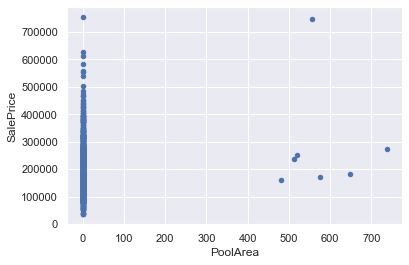

In [28]:
df.plot.scatter(x='PoolArea', y='SalePrice')
plt.show()

Como podemos observar, mi yo de 10 años estaría totalmente equivocado y no hay ninguna relación lineal entre el tamaño (o la existencia) de las piscinas y el precio de las casas. De hecho podemos observar que la mayoría de casas no la tienen y aquellas que sí, sus precios no se alejan mucho del promedio, exceptuando un caso que para este análisis sería un outlier.

#### Relaciones categóricas

En el dataset existe una columna llamada *OverallQual*, la cual alberga un valor entre 1 y 10 asignado por las personas que realizaron el estudio teniendo en cuenta diferentes factores estructurales, de acabados y materiales, entre otros. 1 sería la de peor calidad y 10 la de mejor.

Para iniciar estas relaciones categóricas graficaremos el precio de venta en función de esta variable mediante un diagrama de caja y bigotes o *Boxplot*.

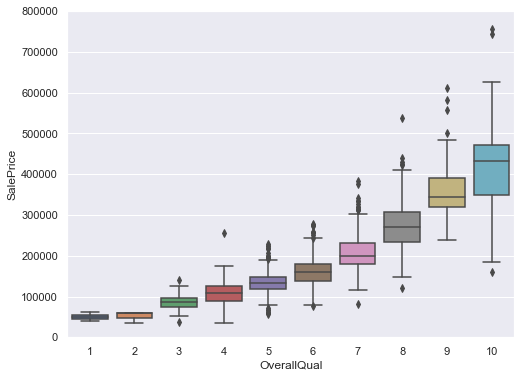

In [27]:
f, ax = plt.subplots(figsize=(8,6)) #Determino el tamaño del gráfico
fig = sns.boxplot(x=df['OverallQual'], y='SalePrice', data=df) 
fig.axis(ymin=0, ymax=800000) #Utilizo el atributo axis para cambiar los límites del gráfico
plt.show()

Con esto podemos ver que la calidad es un factor determinante en el precio de venta de las casas. No obstante, a medida que aumenta la calidad también aumenta el tamaño de las cajas, lo que nos indica también un aumento en la disparidad de precios.

**¿Cómo se relaciona el precio con el año de construcción? ¿Sería correcto inferir que las casas más nuevas son más caras?** En la columna *YearBuilt* del dataset se alberga el año de construcción de las casas. Procederemos entonces a repetir el proceso anterior, pero esta vez graficando el precio en función de dicha variable.

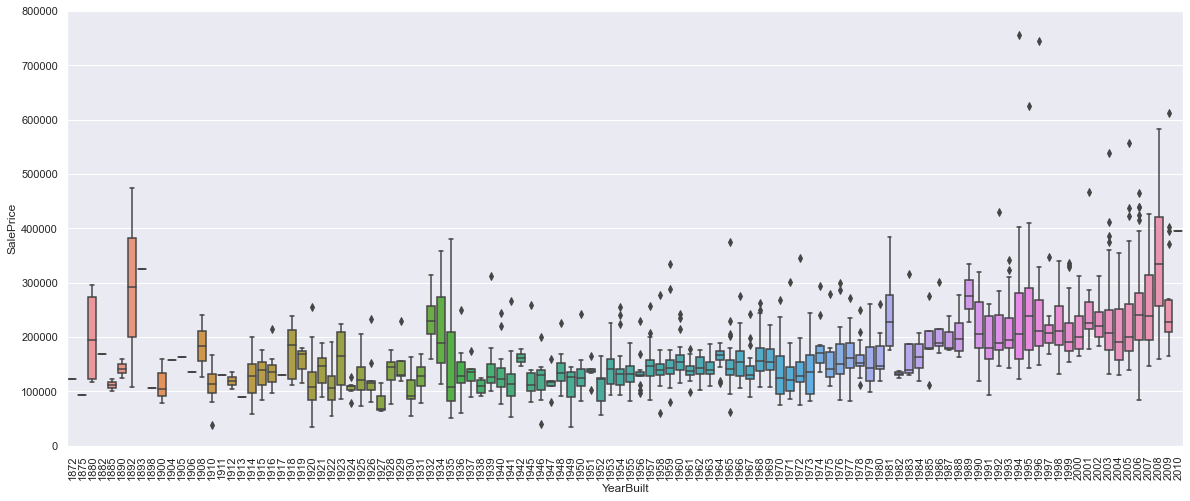

In [25]:
f, ax = plt.subplots(figsize=(20,8)) #Determino el tamaño del gráfico
fig = sns.boxplot(x=df['YearBuilt'], y='SalePrice', data=df) 
fig.axis(ymin=0, ymax=800000) #Utilizo el atributo axis para cambiar los límites del gráfico
plt.xticks(rotation = 90)
plt.show()

Si bien no es una tendencia muy marcada, podemos observar que sí existe una linealidad creciente entre el precio de venta y el año de fabricación. Es decir, lo nuevo tiende a ser más caro. No obstante, hay casas con muy buenos precios que son relativamente viejas.

Bien, este análisis hasta ahora lo he realizado con las variables que creo son relevantes, pero, ¿Qué pasa si hay variables que son relevantes y las estoy dejando por fuera? Para verificar esto, podemos utilizar una matriz de correlaciones, la cual contrasta las variables e indica el valor de linealidad de estas.

In [16]:
corrmat = df.corr()

<AxesSubplot:>

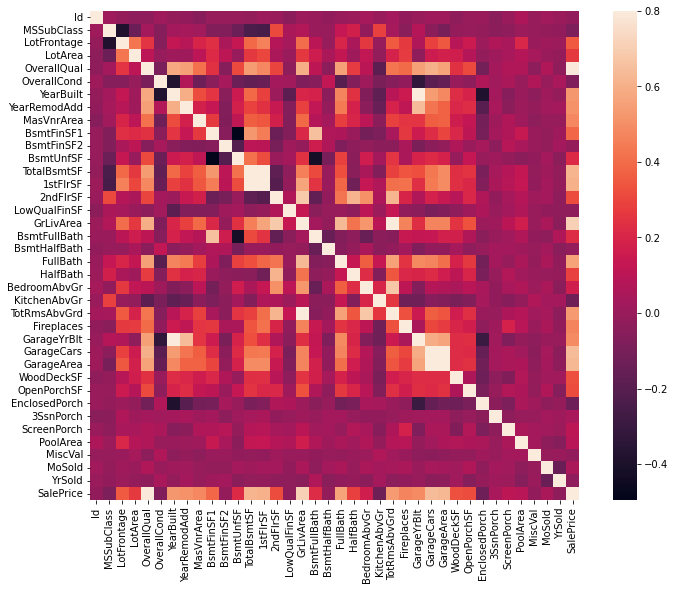

In [17]:
f, ax = plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax = 0.8, square = True)

La matriz gráfica de correlación nos permite ver el grado de correlación lineal entre cada pareja de variables, ¿y qué entendemos por correlación? Bueno, la correlación es una medida estadística que expresa hasta qué punto dos variables están relacionadas. No obstante, la correlación no implica causalidad.

Teniendo en cuenta lo anterior y observando la gráfica, podemos concentrarnos en la fila *SalePrice* y a partir de la tonalidad del color podemos confirmar la importancia de las variables que analizamos anteriormente a partir de la hipótesis (Área total, calidad, área del sótano, año de construcción) pero además, podemos identificar otras variables influyentes que no habíamos tenido en cuenta, como el área del garaje *(GarageArea)*.

Para ver esto más en detalle, seleccionaremos las 10 variables que más se correlacionan con el precio de venta y graficaremos la matriz incluyendo el coeficiente de correlación.

In [26]:
k = 10
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index #El atributo .nlargest nos trae las 10 variables con mayor índice de correlación
cols

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt'],
      dtype='object')

In [19]:
cm = np.corrcoef(df[cols].values.T) #Creo una matriz con los valores transpuestos de las correlaciones usando la librería Numpy
cm

array([[1.        , 0.7909816 , 0.70862448, 0.6404092 , 0.62343144,
        0.61358055, 0.60585218, 0.56066376, 0.53372316, 0.52289733],
       [0.7909816 , 1.        , 0.59300743, 0.60067072, 0.56202176,
        0.5378085 , 0.47622383, 0.55059971, 0.42745234, 0.57232277],
       [0.70862448, 0.59300743, 1.        , 0.46724742, 0.46899748,
        0.4548682 , 0.56602397, 0.63001165, 0.82548937, 0.19900971],
       [0.6404092 , 0.60067072, 0.46724742, 1.        , 0.88247541,
        0.43458483, 0.43931681, 0.46967204, 0.36228857, 0.53785009],
       [0.62343144, 0.56202176, 0.46899748, 0.88247541, 1.        ,
        0.48666546, 0.48978165, 0.40565621, 0.33782212, 0.47895382],
       [0.61358055, 0.5378085 , 0.4548682 , 0.43458483, 0.48666546,
        1.        , 0.81952998, 0.32372241, 0.28557256, 0.391452  ],
       [0.60585218, 0.47622383, 0.56602397, 0.43931681, 0.48978165,
        0.81952998, 1.        , 0.38063749, 0.40951598, 0.28198586],
       [0.56066376, 0.55059971, 0.6300116

In [20]:
sns.set(font_scale = 1.25)

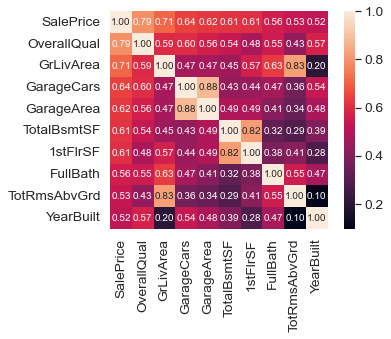

In [22]:
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = '0.2f', 
                 annot_kws={'size':10,}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Con esta matriz podemos ver con mayor claridad y concluir que las variables que más influyen a la hora de determinar el precio de venta de una casa en el Estado de California de Estados Unidos son: Calidad, área total, cantidad de carros en el garaje y área del garaje, tamaño del sótano y tamaño del primer piso, tamaño de los baños, total de habitaciones por encima del nivel del suelo y, por último, el año de construcción que en últimas no es tan determinante.

Si quisiéramos realizar un modelo a partir de este análisis, podríamos depurar más las variables eliminando aquellas que son colineales, es decir, que están vinculadas directamente a otra, como por ejemplo *GarageArea* (colineal con *GarageCars*) y *1stFlrSF* (colineal con *TotalBsmtSF*).

**¿Qué podemos hacer a partir de este análisis?** Bueno, teniendo en cuenta que el objetivo de este análisis no es crear modelos predictivos (por el momento), esta información nos puede servir para sacar **insights** útiles para diseñar estrategias desde diferentes perspectivas, por ejemplo:

### Desde el punto de vista de la inmobiliaria: 

- Énfasis en las variables calidad, área, capacidad del garaje y tamaño del sótano a la hora de comunicar las ofertas

### Desde el punto de vista de las constructoras: 

- Tener en cuenta las variables mencionadas a la hora de la distribución de los espacios en el diseño de las casas con el fin de construir un producto de mayor valor en el mercado

### Desde el punto de vista del comprador:

- Aprovechar ofertas a precios asequibles, incluso si están en sectores no tan atractivos pero en crecimiento, teniendo en cuenta el estado de estas variables, garantizando así una valorización futura de la propiedad

- En caso de que el presupuesto no sea muy alto, analizar de qué factores se puede prescindir con el fin de encontrar una oferta más económica (Tamaño del sótano, por ejemplo)



Por último, mediante el gráfico *pairplot* de *Seaborn* graficamos la misma matriz de correlaciones pero, esta vez, representadas con gráficos de dispersión.

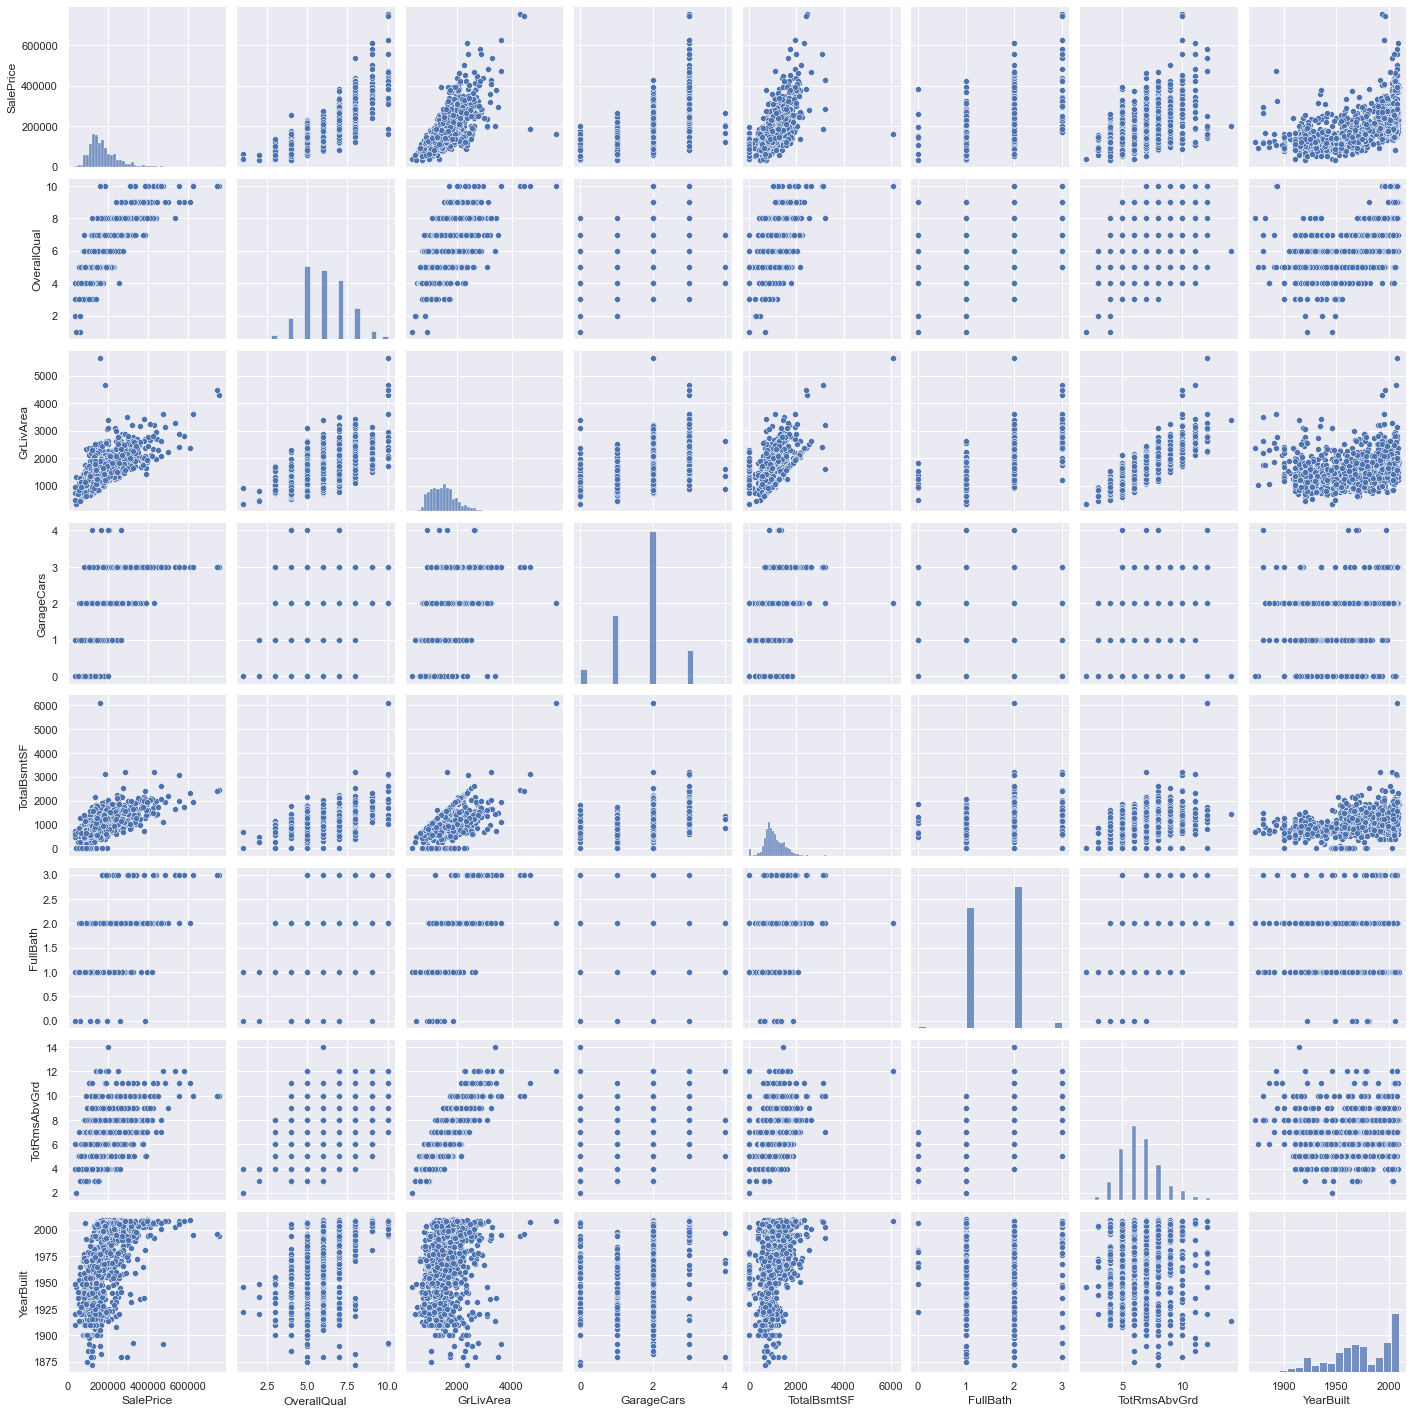

In [23]:
sns.set() #Usar configuración por defecro de seaborn

cols_act = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars',
       'TotalBsmtSF', 'FullBath', 'TotRmsAbvGrd', 'YearBuilt']

sns.pairplot(df[cols_act], height = 2.5)

plt.show()